# Disease Outbreak Response Decision-making Under Uncertainty: A retrospective analysis of measles in Sao Paulo

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
import pdb

np.random.seed(42509)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [7]:
data_dir = "data/"

Import outbreak data

In [8]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0, encoding='latin-1')
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [9]:
measles_data = (measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})
                    .drop('AGE', axis=1))

Sao Paulo population by district

In [10]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [11]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [12]:
sp_pop.head(3)

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249


Plot of cumulative cases by district

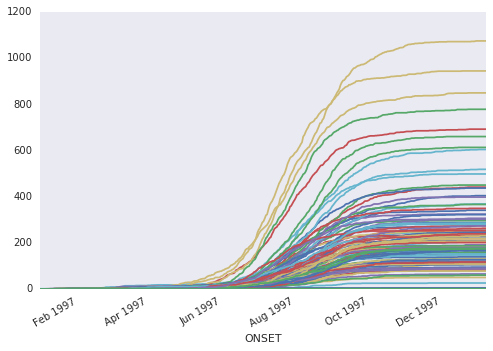

In [13]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

Age distribution of cases, by confirmation status

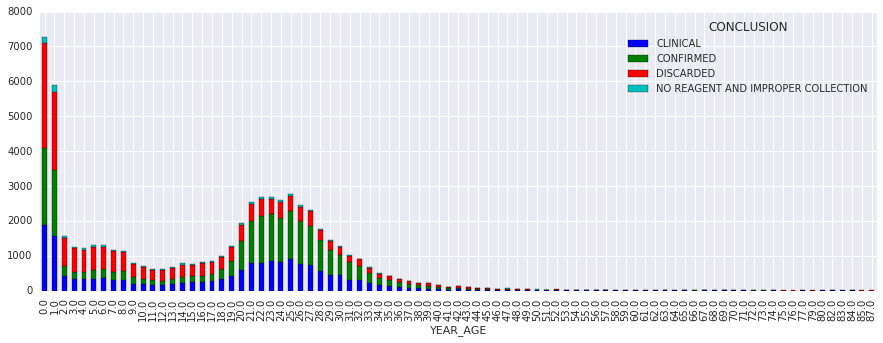

In [14]:
by_conclusion = measles_data.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5))

### Vaccination Data

In [15]:
vaccination_data = pd.read_csv('data/BrazilVaxRecords.csv', index_col=0)
vaccination_data.head()

,BIRTHS,VAX,POP,SIA
YEAR,,,,
1980,3896442,0.57,121740438,0
1981,3933136,0.73,124610790,0
1982,3952137,0.66,127525420,0
1983,3952735,0.68,130455659,0
1984,3935224,0.73,133364277,0


Calculate residual susceptibility from routine vaccination

In [16]:
vax_97 = np.r_[[0]*(1979-1921+1), vaccination_data.VAX[:17]]
n = len(vax_97)
FOI_mat = np.resize((1 - vax_97*0.9), (n,n)).T

In [17]:
vacc_susc = (1 - vax_97*0.9)[::-1]
vacc_susc[0] = 0.5

Susceptiblity accounting for SIAs

In [18]:
sia_susc = np.ones(len(vax_97))
birth_year = np.arange(1922, 1998)[::-1]
by_mask = (birth_year > 1983) & (birth_year < 1992)
sia_susc[by_mask] *= 0.2

## Compilation of cases into 2-week intervals by age class

Age classes are defined in 5-year intervals. We will combine 40+ ages into a single class.

In [19]:
age_classes = [0,5,10,15,20,25,30,35,40,100]
measles_data.dropna(subset=['YEAR_AGE'], inplace=True)
measles_data['YEAR_AGE'] = measles_data.YEAR_AGE.astype(int)
measles_data['AGE_GROUP'] = pd.cut(measles_data.YEAR_AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [20]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

Extract lab-confirmed and clinical-confirmed subsets, with no missing county information.

In [21]:
lab_subset = measles_data[(CONFIRMED | DISCARDED) & measles_data.COUNTY.notnull()].copy()

In [22]:
age = lab_subset.YEAR_AGE.values
ages = lab_subset.YEAR_AGE.unique()
counties = lab_subset.COUNTY.unique()
confirmed = (lab_subset.CONCLUSION=='CONFIRMED').values

In [23]:
clinic_subset = measles_data[CLINICAL & measles_data.COUNTY.notnull()].copy()

Histogram of lab subset, by outcome.

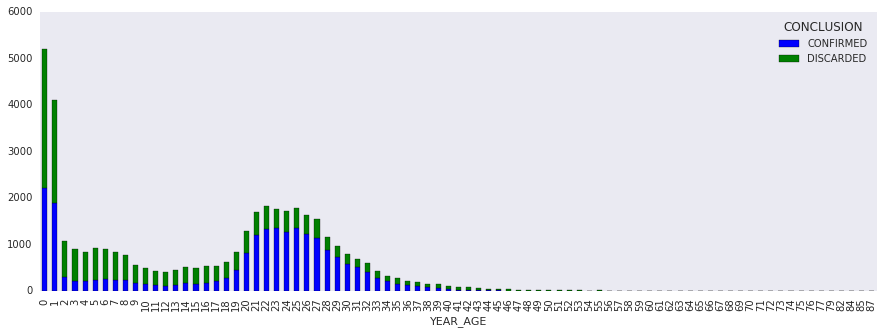

In [24]:
_lab_subset = lab_subset.replace({"CONCLUSION": {"CLINICAL": "UNCONFIRMED"}})
by_conclusion = _lab_subset.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5), grid=False)

In [25]:
lab_subset.shape

(41547, 15)

Define age groups

In [26]:
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])
age_groups = age_group.categories
age_groups

Index(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 100)'],
      dtype='object')

In [27]:
age_slice_endpoints = [g[1:-1].split(',') for g in age_groups]
age_slices = [slice(int(i[0]), int(i[1])) for i in age_slice_endpoints]

Get index from full cross-tabulation to use as index for each district

In [28]:
dates_index = measles_data.groupby(['ONSET', 'AGE_GROUP']).size().unstack().index

## Cleanup of Sao Paulo population data

Match age groupings, exclude invalid districts.

In [29]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [30]:
excludes = ['BOM RETIRO']

N = sp_pop.drop(excludes).ix[unique_districts].sum().drop('Total')

In [31]:
N_age = N.iloc[:8]
N_age.index = age_groups[:-1]
N_age[age_groups[-1]] = N.iloc[8:].sum()

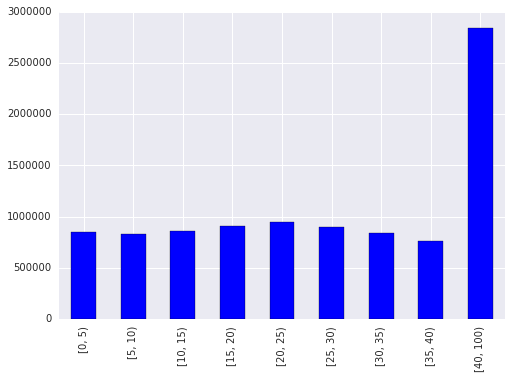

In [32]:
N_age.plot(kind='bar')

Compile bi-weekly confirmed and unconfirmed data by Sao Paulo district

In [33]:
# All confirmed cases, by district
confirmed_data = lab_subset[lab_subset.CONCLUSION=='CONFIRMED']
confirmed_counts = (confirmed_data.groupby(['ONSET', 'AGE_GROUP'])
                    .size()
                    .unstack()
                    .reindex(dates_index)
                    .fillna(0)
                    .sum())

all_confirmed_cases = (confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique())
                       .fillna(0).values.astype(int))

In [34]:
confirmed_counts_2w = (confirmed_data
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .reindex(dates_index)
                        .fillna(0)
                        .resample('2W', how='sum'))

In [35]:
# All clinical cases, by district
clinical_counts = (clinic_subset.groupby(['ONSET', 'AGE_GROUP'])
                   .size()
                   .unstack()
                   .reindex(dates_index)
                   .fillna(0)
                   .sum())

all_clinical_cases = (clinical_counts.reindex_axis(measles_data['AGE_GROUP'].unique())
                      .fillna(0).values.astype(int))

In [36]:
clinical_counts_2w = (clinic_subset
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .reindex(dates_index)
                        .fillna(0)
                        .resample('2W', how='sum'))

In [37]:
confirmed_counts_2w.head()

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,0,0,0,0,1,0,0,0,0
1997-01-19,0,1,0,0,3,4,0,0,0
1997-02-02,4,1,0,0,2,1,0,0,0
1997-02-16,4,0,0,0,2,1,1,0,0
1997-03-02,9,0,0,2,4,5,1,0,1


In [38]:
clinical_counts_2w.head()

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,3,1,1,0,0,0,0,0,0
1997-01-19,30,3,1,1,1,3,2,1,0
1997-02-02,22,4,0,2,1,1,1,0,1
1997-02-16,21,2,2,2,2,1,1,0,2
1997-03-02,24,5,2,5,2,2,2,1,0


Check shape of data frame

- 28 bi-monthly intervals, 9 age groups

In [39]:
assert clinical_counts_2w.shape == (28, len(age_groups))

## Stochastic Disease Transmission Model

We will extend a simple SIR disease model, to account for confirmation status, which will be fit using MCMC.

This model fits the series of 2-week infection totals for each age group $a$ as a set of Poisson random variables:

\\[Pr(I_{a}(t) | \lambda_a(t)) = \text{Poisson}(\lambda_a(t)) \\]

Where the age-specific outbreak intensity at time $t$ is modeled as:

\\[\lambda_a(t) = S_a(t-1) \frac{I(t-1)\mathbf{B}}{N_a} \\]

where $S_a(t-1)$ is the number of susceptibles in age group $a$ in the previous time period, $I(t-1)$ an age-specific vector of the number of infected individuals in the previous time period, $\mathbf{B}$ a matrix of transmission coefficients (both within- and between-ages), and $N_a$ an estimate of the population of age-$a$ people in Sao Paulo.

The matrix $B$ was constructed from a scalar transmission parameter $\beta$, which was given a vague half-Cauchy prior (scale=25). This was used to represent within-age-group transmission, and hence placed on the diagonal of a square transmission matrix of size $A$. Off-diagonal elements, representing transmission between age groups were scaled by a decay parameter $\delta$ which was used to scale the transmission to adjacent groups according to:

\\[\beta \delta^{|a-b|}\\]

where a and b are indices of two age group. The resulting transmission matrix is parameterized as follows:

$$\begin{aligned}
\mathbf{B} = \left[{
\begin{array}{c}
  {\beta} & {\beta \delta} & {\beta \delta^2}& \ldots & {\beta \delta^{A-2}} & {\beta \delta^{A-1}}  \\
  {\beta \delta} & {\beta} &  \beta \delta & \ldots & {\beta \delta^{A-3}}  & {\beta \delta^{A-2}} \\
  {\beta \delta^2} & \beta \delta & {\beta} & \ldots & {\beta \delta^{A-4}} & {\beta \delta^{A-3}} \\
  \vdots & \vdots & \vdots &  & \vdots & \vdots\\
  {\beta \delta^{A-2}} & {\beta \delta^{A-3}} & {\beta \delta^{A-4}} & \ldots &  {\beta} & \beta \delta  \\
{\beta \delta^{A-1}} & {\beta \delta^{A-2}} & \beta \delta^{A-3} & \ldots & \beta \delta &  {\beta} 
\end{array}
}\right]
\end{aligned}$$

The basic reproductive number $R_0$ was calculated as the largest real-valued eigenvalue of the matrix $\mathbf{B}$. To impose a mild constraint on $R_0$, we applied a Gaussian prior distribution whose 1st and 99th quantiles are 8 and 24, respectively, a reasonable range for a measles outbreak:

In [40]:
from scipy.stats import norm

def normal_from_quantiles(x, p=[0.05, 0.95]):
    denom = norm.ppf(p[1]) - norm.ppf(p[0])
    σ = (x[1] - x[0]) / denom
    μ = (x[0]*norm.ppf(p[1]) - x[1]*norm.ppf(p[0])) / denom
    return μ, σ

In [41]:
normal_from_quantiles([8, 24], p=[0.01, 0.99])

(16.0, 3.4388665982719462)

In [42]:
from pymc import MCMC, Matplot, AdaptiveMetropolis, MAP
from pymc import (Uniform, DiscreteUniform, Beta, Binomial, Normal, 
                  CompletedDirichlet, Pareto,
                  Poisson, NegativeBinomial, negative_binomial_like, poisson_like,
                  Lognormal, Exponential, binomial_like,
                  TruncatedNormal, Binomial, Gamma, HalfCauchy, normal_like,
                  MvNormalCov, Bernoulli, Uninformative, 
                  Multinomial, rmultinomial, rbinomial,
                  Dirichlet, multinomial_like, uniform_like)
from pymc import (Lambda, observed, invlogit, deterministic, potential, stochastic, logit)

def measles_model(obs_date, confirmation=True, migrant=False, constrain_R=True):
    
    '''
    Confirmation sub-model
    '''
    
    if confirmation:

        # Specify priors on age-specific means
        age_classes = np.unique(age_index)

        μ = Normal("μ", mu=0, tau=0.0001, value=[0]*len(age_classes))
        σ = HalfCauchy('σ', 0, 25, value=1)
        var = σ**2
        ρ = Uniform('ρ', -1, 1, value=0)

        # Build variance-covariance matrix with first-order correlation 
        # among age classes
        @deterministic
        def Σ(var=var, cor=ρ):
            I = np.eye(len(age_classes))*var
            E = np.diag(np.ones(len(age_classes)-1), k=-1)*var*cor
            return I + E + E.T

        # Age-specific probabilities of confirmation as multivariate normal 
        # random variables
        β_age = MvNormalCov("β_age", mu=μ, C=Σ, value=[1]*len(age_classes))
        p_age = Lambda('p_age', lambda b=β_age: invlogit(b))

        @deterministic(trace=False)
        def p_confirm(b=β_age):
            return invlogit(b[age_index])


        # Confirmation likelihood
        lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, value=confirmed, 
                                observed=True)


    '''
    Truncate data at observation period
    '''
    obs_index = clinical_counts_2w.index <= obs_date
    confirmed_obs_t = confirmed_counts_2w[obs_index].values.astype(int)
    clinical_obs_t = clinical_counts_2w[obs_index].values.astype(int)
                        
    n_periods, n_age_groups = confirmed_obs_t.shape

    # Index for observation date, used to index out values of interest 
    # from the model.
    t_obs = obs_index.sum() - 1
    
    if confirmation:
        
        @stochastic(dtype=int)
        def clinical_cases(value=(clinical_obs_t*0.5).astype(int), 
                            n=clinical_obs_t, p=p_age):
            # Binomial confirmation process
            return np.sum([binomial_like(xi, ni, p) for xi,ni in zip(value,n)])
        I = Lambda('I', lambda clinical=clinical_cases: 
                           clinical + confirmed_obs_t.astype(int))

        assert I.value.shape == (t_obs +1, n_age_groups)
        
        age_dist_init = np.sum(I.value, 0)/ float(I.value.sum())
        
    else:
        
        I = confirmed_obs_t + clinical_obs_t

        assert I.shape == (t_obs +1, n_age_groups)
        
        age_dist_init = np.sum(I, 0) / float(I.sum())
        
    
    # Calcuate age distribution from observed distribution of infecteds to date
    _age_dist = Dirichlet('_age_dist', np.ones(n_age_groups), 
                         value=age_dist_init[:-1]/age_dist_init.sum())
    age_dist = CompletedDirichlet('age_dist', _age_dist)
    
    @potential
    def age_dist_like(p=age_dist, I=I):
        return multinomial_like(I.sum(0), I.sum(), p)

    
    '''
    Disease transmission model
    '''

    # Transmission parameter
    β = HalfCauchy('β', 0, 25, value=3) #[1]*n_age_groups) 
    decay = Beta('decay', 1, 5, value=0.9)

    @deterministic
    def B(b=β, d=decay):
        b = np.ones(n_age_groups)*b
        B = b*np.eye(n_age_groups)
        for i in range(1, n_age_groups):
            B += np.diag(np.ones(n_age_groups-i)*b[i:]*d**i, k=-i) 
            B += np.diag(np.ones(n_age_groups-i)*b[:-i]*d**i, k=i)
        return B

    # Downsample annual series to observed age groups
    downsample = lambda x: np.array([x[s].mean() for s in age_slices])

    @deterministic
    def R0(B=B):
        evs = np.linalg.eigvals(B)
        return max(evs[np.isreal(evs)])
    
    if constrain_R:
        @potential
        def constrain_R0(R0=R0):
            # Weakly-informative prior to constrain R0 to be within the 
            # typical measles range
            return normal_like(R0, 16, 3.4**-2)


    A = Lambda('A', lambda R0=R0: 75./(R0 - 1))
    lt_sum = downsample(np.tril(FOI_mat).sum(0)[::-1])
    natural_susc = Lambda('natural_susc', lambda A=A: np.exp((-1/A) * lt_sum))

    @deterministic
    def p_μ(natural_susc=natural_susc): 
        return downsample(sia_susc) * downsample(vacc_susc) * natural_susc
    
    if True:
        # Following Stan manual chapter 16.2
        λ_p = Pareto('λ_p', 0.1, 1.5)

        a = Lambda('a', lambda mu=p_μ, lam=λ_p: mu*lam )
        b = Lambda('b', lambda mu=p_μ, lam=λ_p: (1-mu)*lam)

        p_susceptible = Beta('p_susceptible', a, b, value=p_μ.value)
        
    else:
        
        p_σ = HalfCauchy('p_σ', 0, 5, value=1)
        
        m = Lambda('m', lambda p=p_μ: logit(p))
        
        θ_p = Normal('theta_p', m, p_σ)
        
        p_susceptible = Lambda('p_susceptible', lambda θ_p=θ_p: invlogit(θ_p))
        

    # Estimated total initial susceptibles
    S_0 = Binomial('S_0', n=N_age.values.astype(int), p=p_susceptible)
    
    '''
    Model of migrant influx of susceptibles
    '''
    if migrant:
    
        # Data augmentation for migrant susceptibles
        imaginary_migrants = 1000000
        N_migrant = DiscreteUniform('N_migrant', 0, imaginary_migrants, value=100000)
        μ_age = Uniform('μ_age', 15, 35, value=25)
        σ_age = Uniform('σ_age', 1, 10, value=5)
        M_age = Normal('M_age', μ_age, σ_age**-2, 
                       size=imaginary_migrants, trace=False)

        @deterministic
        def M_0(M=M_age, N=N_migrant):
            # Take first N augmented susceptibles
            M_real = M[:N]
            # Drop into age groups
            M_group = pd.cut(M_real, 
                             [0, 5, 10, 15, 20, 25, 30, 35, 40, 100], 
                             right=False)
            return M_group.value_counts().values

        p_migrant = Lambda('p_migrant', lambda M_0=M_0, S_0=S_0: M_0/(M_0 + S_0))

        I_migrant = [Binomial('I_migrant_%i' % i, I[i], p_migrant) 
                             for i in range(t_obs + 1)]

        I_local = Lambda('I_local', 
                lambda I=I, I_m=I_migrant: 
                         np.array([Ii - Imi for Ii,Imi in zip(I,I_m)]))
        S = Lambda('S', lambda I=I, S_0=S_0, M_0=M_0: S_0 + M_0 - I.cumsum(0))
        S_local = Lambda('S_local', lambda I=I_local, S_0=S_0: S_0 - I.cumsum(0))


    else:

        # Remaining susceptibles at each 2-week period
        S = Lambda('S', lambda I=I, S_0=S_0: S_0 - I.cumsum(axis=0))
    
    # Check shape
    assert S.value.shape == (t_obs+1., n_age_groups)
    

    # Susceptibles at time t, by age
    S_age = Lambda('S_age', lambda S=S: S[-1].astype(int))
    
    # Force of infection
    @deterministic
    def λ(B=B, I=I, S=S): 
        return S * (I.dot(B) / N_age.values)

    # Check shape
    assert λ.value.shape == (t_obs+1, n_age_groups)
    
    
    # FOI in observation period
    λ_t = Lambda('λ_t', lambda lam=λ: lam[-1])
    
    # Effective reproductive number
    R_t = Lambda('R_t', lambda S=S, R0=R0: S.sum(1) * R0 / N_age.sum())

    # Poisson likelihood for observed cases
    @potential
    def new_cases(I=I, lam=λ):
        return poisson_like(I[1:], lam[:-1])
    
    '''
    Vaccination targets
    '''
    
    @deterministic
    def vacc_5(S=S_age):
        # Vaccination of 5 and under
        p = [0.95] + [0]*(n_age_groups - 1)
        return rbinomial(S, p)
    
    # Proportion of susceptibles vaccinated
    pct_5 = Lambda('pct_5', 
                lambda V=vacc_5, S=S_age: V.sum()/S.sum())


    @deterministic
    def vacc_15(S=S_age):
        # Vaccination of 15 and under
        p = [0.95]*3 + [0]*(n_age_groups - 3)
        return rbinomial(S, p)
    
    # Proportion of susceptibles vaccinated
    pct_15 = Lambda('pct_15', 
            lambda V=vacc_15, S=S_age: V.sum()/S.sum())
    
    @deterministic
    def vacc_30(S=S_age):
        # Vaccination of 30 and under
        p = [0.95]*6 + [0]*(n_age_groups - 6)
        return rbinomial(S, p)
    
    # Proportion of 30 and under susceptibles vaccinated
    pct_30 = Lambda('pct_30', 
            lambda V=vacc_30, S=S_age: V.sum()/S.sum())
    
    @deterministic
    def vacc_adult(S=S_age):
        # Vaccination of adults under 30 (and young kids)
        p = [0.95, 0, 0, 0, 0.95, 0.95] + [0]*(n_age_groups - 6)
        return rbinomial(S, p)
    
    # Proportion of adults under 30 (and young kids)
    pct_adult = Lambda('pct_adult', 
            lambda V=vacc_adult, S=S_age: V.sum()/S.sum())

    return locals()

ImportError: No module named 'pymc'

In [49]:
!pip3 install --user -U numpy

  Using cached numpy-1.11.0.tar.gz
  Running setup.py install for numpy
You are using pip version 7.1.2, however version 8.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Model execution

Run models for June 15 and July 15 observation points, both with and without clinical confirmation.

In [50]:
n_iterations = 50000
n_burn = 40000
backend = 'sqlite'
migrant = True

In [51]:
if False:
    import ipyparallel as ipp

    rc = ipp.Client()
    lbv = rc.load_balanced_view()

June 15, with lab confirmation

In [52]:
model_june = MCMC(measles_model('1997-06-15', migrant=migrant), 
                  db=backend, name='model_june')

In [53]:
model_june.sample(n_iterations, n_burn)

 [-----------------80%----------        ] 40002 of 50000 complete in 7194.7 sec

/Users/fonnescj/Repositories/pymc/pymc/database/base.py:282: UserWarning: 
Error tallying Metropolis_p_susceptible_adaptive_scale_factor, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "/Users/fonnescj/Repositories/pymc/pymc/database/base.py", line 272, in tally
    warnings.warn("""
  File "/Users/fonnescj/Repositories/pymc/pymc/database/sqlite.py", line 95, in tally
    self.db.cur.execute(query)
sqlite3.OperationalError: no such table: Metropolis_p_susceptible_adaptive_scale_factor

  def connect_model(self, model):
/Users/fonnescj/Repositories/pymc/pymc/database/base.py:282: UserWarning: 
Error tallying Metropolis_λ_p_adaptive_scale_factor, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (m

 [-----------------100%-----------------] 50001 of 50000 complete in 9031.3 sec

July 15, with lab confirmation

In [54]:
model_july = MCMC(measles_model('1997-07-15', migrant=migrant), 
                  db=backend, name='model_july')

In [55]:
model_july.sample(n_iterations, n_burn)

 [-----------------80%----------        ] 40000 of 50000 complete in 7437.2 sec

/Users/fonnescj/Repositories/pymc/pymc/database/base.py:282: UserWarning: 
Error tallying Metropolis_p_susceptible_adaptive_scale_factor, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "/Users/fonnescj/Repositories/pymc/pymc/database/base.py", line 272, in tally
    warnings.warn("""
  File "/Users/fonnescj/Repositories/pymc/pymc/database/sqlite.py", line 95, in tally
    self.db.cur.execute(query)
sqlite3.OperationalError: no such table: Metropolis_p_susceptible_adaptive_scale_factor

  def connect_model(self, model):
/Users/fonnescj/Repositories/pymc/pymc/database/base.py:282: UserWarning: 
Error tallying Metropolis_λ_p_adaptive_scale_factor, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (m

 [-----------------100%-----------------] 50001 of 50000 complete in 9403.8 sec

June 15, no lab confirmation

In [56]:
model_june_noconf = MCMC(measles_model('1997-06-15', confirmation=False, migrant=migrant), 
                  db=backend, name='model_june_noconf')

In [57]:
model_june_noconf.sample(n_iterations, n_burn)

 [-----------------80%----------        ] 40002 of 50000 complete in 6776.5 sec

/Users/fonnescj/Repositories/pymc/pymc/database/base.py:282: UserWarning: 
Error tallying Metropolis_p_susceptible_adaptive_scale_factor, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "/Users/fonnescj/Repositories/pymc/pymc/database/base.py", line 272, in tally
    warnings.warn("""
  File "/Users/fonnescj/Repositories/pymc/pymc/database/sqlite.py", line 95, in tally
    self.db.cur.execute(query)
sqlite3.OperationalError: no such table: Metropolis_p_susceptible_adaptive_scale_factor

  def connect_model(self, model):
/Users/fonnescj/Repositories/pymc/pymc/database/base.py:282: UserWarning: 
Error tallying Metropolis_λ_p_adaptive_scale_factor, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (m

 [-----------------100%-----------------] 50000 of 50000 complete in 8511.3 sec

July 15, no lab confirmation

In [58]:
model_july_noconf = MCMC(measles_model('1997-07-15', confirmation=False, migrant=migrant), 
                  db=backend, name='model_july_noconf')

In [59]:
model_july_noconf.sample(n_iterations, n_burn)

 [---------------- 42%                  ] 21198 of 50000 complete in 3797.7 secHalting at iteration  21199  of  50000


## Summary of model output

Estimate of R0 for june (with confirmation submodel)

Plotting R0


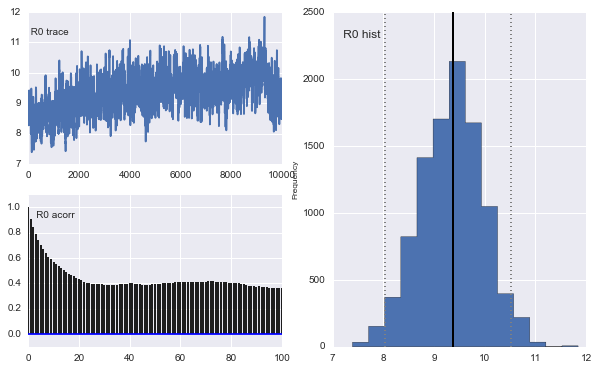

In [61]:
if model_june.R0.value.shape:
    Matplot.summary_plot(model_june.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_june.R0)

Estimate of R0 for june (no confirmation submodel)

Plotting R0


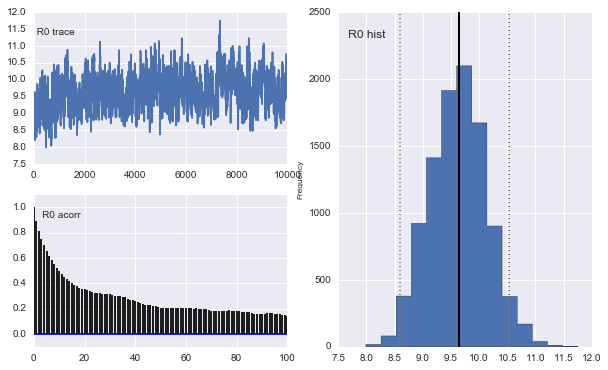

In [62]:
if model_june.R0.value.shape:
    Matplot.summary_plot(model_june_noconf.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_june_noconf.R0)

Estimate of R0 for july (with confirmation submodel)

Plotting R0


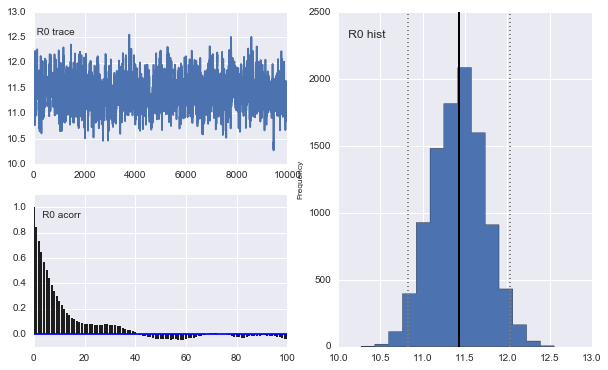

In [63]:
if model_july.β.shape:
    Matplot.summary_plot(model_july.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_july.R0)

Estimate of R0 for july (no confirmation submodel)

Plotting R0


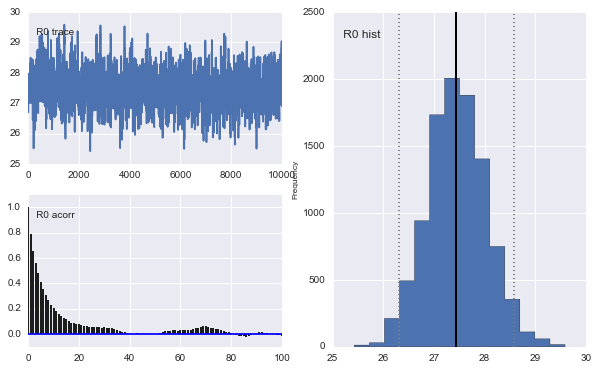

In [51]:
if model_july_noconf.β.shape:
    Matplot.summary_plot(model_july_noconf.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_july_noconf.R0)

Lab confirmation rates, June model

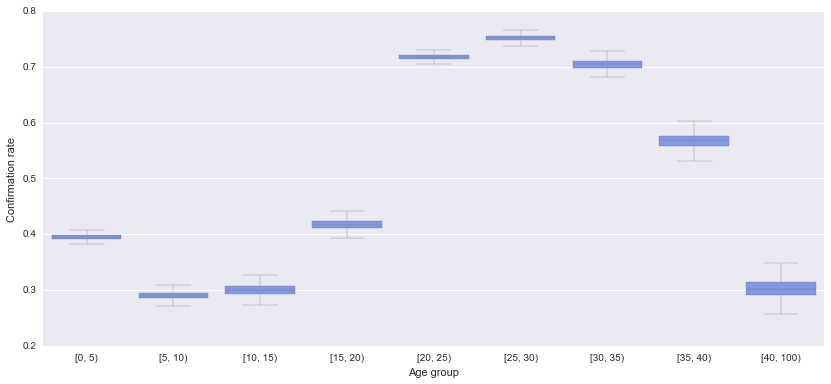

In [52]:
p_age = pd.DataFrame(model_june.p_age.trace(), columns=age_groups)

f, axes = plt.subplots(figsize=(14,6))
sb.boxplot(data=p_age, linewidth=0.3, fliersize=0, ax=axes,
          color=sb.color_palette("coolwarm", 5)[0],
          order=age_group.categories)
axes.set_ylabel('Confirmation rate')
axes.set_xlabel('Age group')

Proportion of **local** population susceptible, June model.

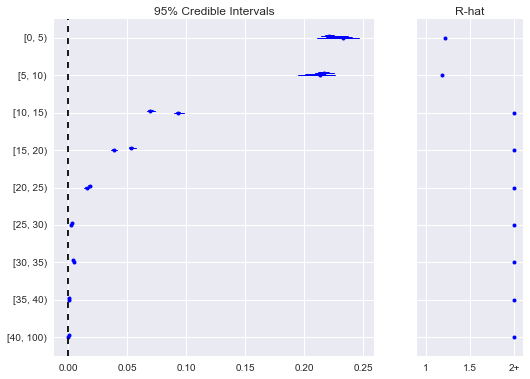

In [53]:
Matplot.summary_plot(model_june.p_susceptible, custom_labels=age_groups)

Proportion of **local** population susceptible, June model with no confirmation correction

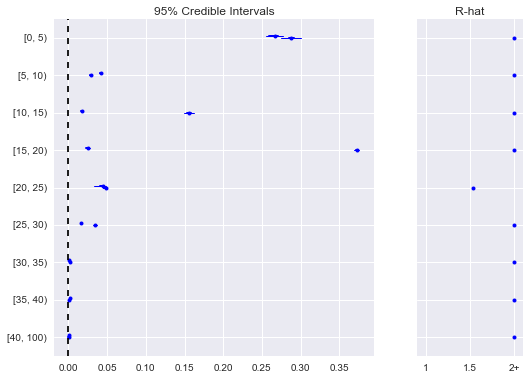

In [54]:
Matplot.summary_plot(model_june_noconf.p_susceptible, custom_labels=age_groups)

Epidemic intensity estimates at June or July observation time, by age group.

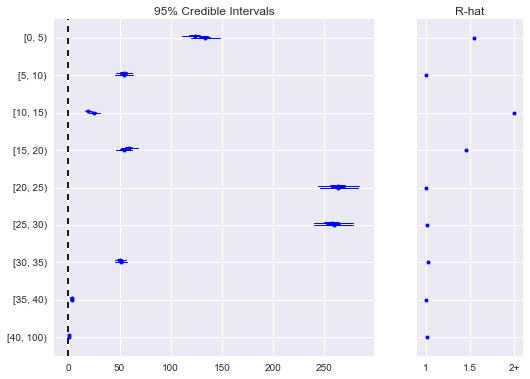

In [55]:
Matplot.summary_plot(model_june.λ_t, custom_labels=age_groups)

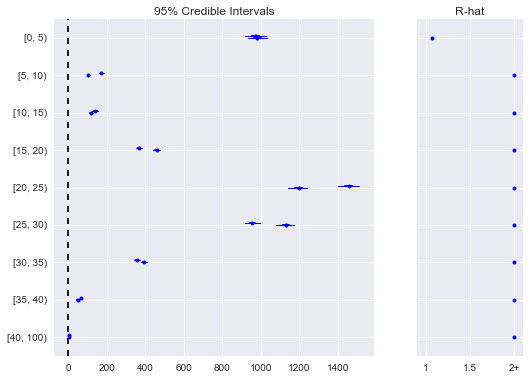

In [56]:
Matplot.summary_plot(model_july.λ_t, custom_labels=age_groups)

Time series of epidemic intensities for lab- versus clinical-confirmation models, for each age group.

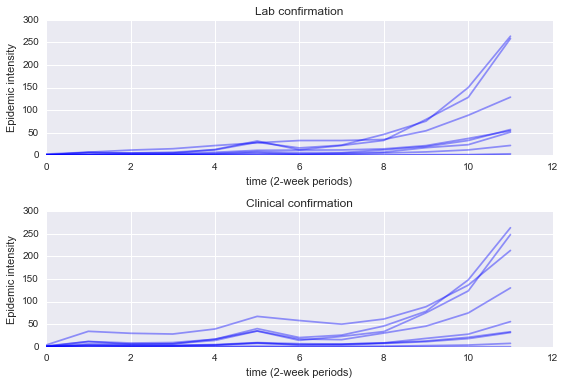

In [57]:
lam_june = model_june.λ.stats()

fig, axes = plt.subplots(2, 1, sharey=True)

axes[0].plot(lam_june['quantiles'][50], 'b-', alpha=0.4)
axes[0].set_ylabel('Epidemic intensity')
axes[0].set_xlabel('time (2-week periods)')
axes[0].set_title('Lab confirmation')

lam_june_noconf = model_june_noconf.λ.stats()

axes[1].plot(lam_june_noconf['quantiles'][50], 'b-', alpha=0.4)
axes[1].set_ylabel('Epidemic intensity')
axes[1].set_xlabel('time (2-week periods)')
axes[1].set_title('Clinical confirmation')

plt.tight_layout()

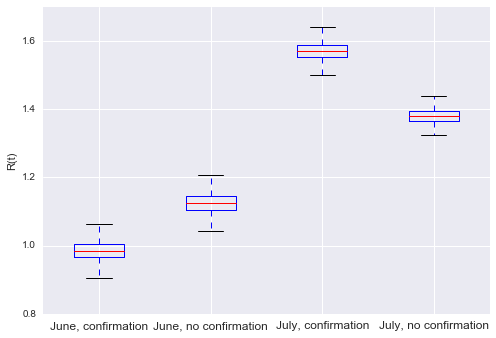

In [58]:
Rt_values = pd.DataFrame(np.c_[model_june.R_t.trace()[:, -1],
                          model_june_noconf.R_t.trace()[:, -1],
                         model_july.R_t.trace()[:, -1],
                         model_july_noconf.R_t.trace()[:, -1]],
                        columns=['June, confirmation', 'June, no confirmation',
                                'July, confirmation', 'July, no confirmation'])

ax = Rt_values.boxplot(return_type='axes');
ax.set_ylabel('R(t)')

In [59]:
S_age_june = pd.DataFrame(model_june.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_june.columns = 'Age', 'Iteration', 'S'
S_age_june['Confirmation'] = 'Lab'

S_age_june_noconf = pd.DataFrame(model_june_noconf.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_june_noconf.columns = 'Age', 'Iteration', 'S'
S_age_june_noconf['Confirmation'] = 'Clinical'

S_age_june = pd.concat([S_age_june, S_age_june_noconf], ignore_index=True)

In [60]:
S_age_july = pd.DataFrame(model_july.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_july.columns = 'Age', 'Iteration', 'S'
S_age_july['Confirmation'] = 'Lab'

S_age_july_noconf = pd.DataFrame(model_july_noconf.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_july_noconf.columns = 'Age', 'Iteration', 'S'
S_age_july_noconf['Confirmation'] = 'Clinical'

S_age_july = pd.concat([S_age_july, S_age_july_noconf], ignore_index=True)

Numbers of suscepibles in each age group, under lab vs clinical confirmation

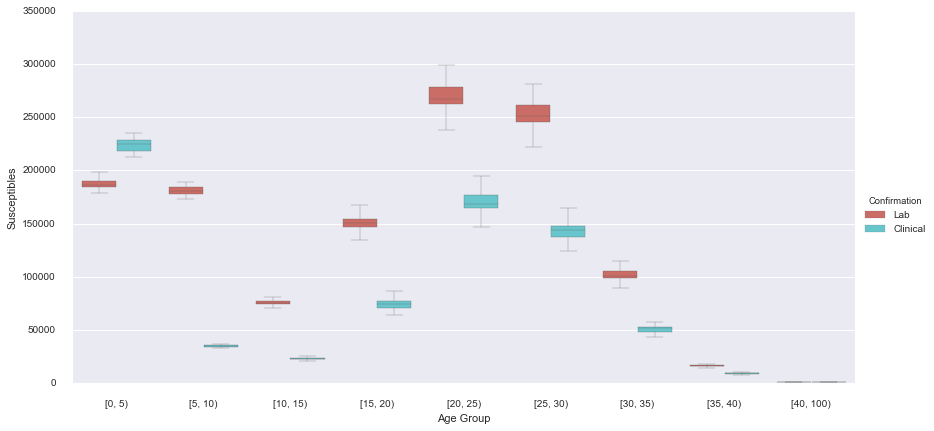

In [61]:
g = sb.factorplot("Age", "S", "Confirmation", S_age_june, kind="box",
                   palette="hls", size=6, aspect=2, linewidth=0.3, fliersize=0, 
                  order=age_group.categories)
g.despine(offset=10, trim=True)
g.set_axis_labels("Age Group", "Susceptibles");

### Vaccination coverage by strategy

In [62]:
model_june.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.146            0.007            0.0              [ 0.132  0.158]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.133            0.141           0.146          0.15          0.159
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.348            0.013            0.001            [ 0.322  0.371]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.323            0.339           0.347          0.357         0.372
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [63]:
june_coverage = pd.DataFrame({name: model_june.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_coverage['Month'] = 'June'
june_coverage['Confirmation'] = 'Lab'

In [64]:
june_noconf_coverage = pd.DataFrame({name: model_june_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_noconf_coverage['Month'] = 'June'
june_noconf_coverage['Confirmation'] = 'Clinical'

july_coverage = pd.DataFrame({name: model_july.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_coverage['Month'] = 'July'
july_coverage['Confirmation'] = 'Lab'

july_noconf_coverage = pd.DataFrame({name: model_july_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_noconf_coverage['Month'] = 'July'
july_noconf_coverage['Confirmation'] = 'Clinical'

In [65]:
coverage = pd.concat([june_coverage, june_noconf_coverage, july_coverage, july_noconf_coverage], 
                     ignore_index=True)

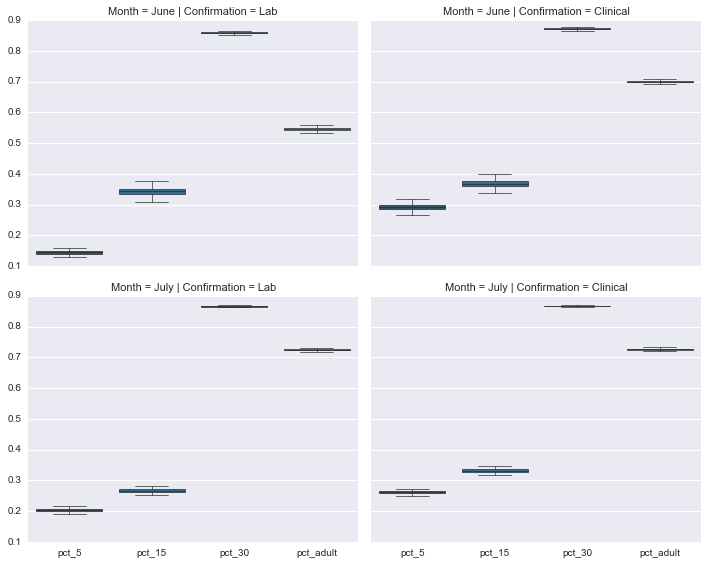

In [66]:
sb.factorplot(row="Month", col="Confirmation", data=coverage, kind='box',
              row_order=['June', 'July'],
              order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'],
               palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)

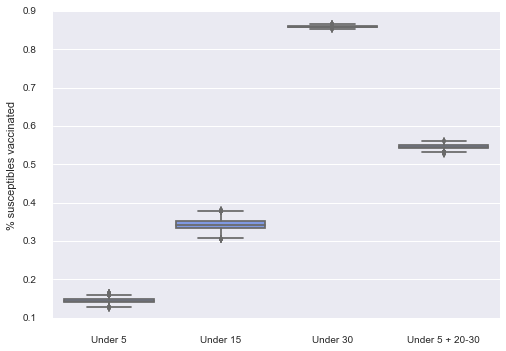

In [67]:
axes = sb.boxplot(data=june_coverage, order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'], 
                  color=sb.color_palette("coolwarm", 5)[0])
axes.set_xticklabels(['Under 5', 'Under 15', 'Under 30', 'Under 5 + 20-30'])
axes.set_ylabel('% susceptibles vaccinated')
sb.despine(offset=10, trim=True)

In [68]:
model_june_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.214            0.078            0.008            [ 0.13   0.306]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.131            0.137           0.249          0.293         0.309
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.302            0.066            0.007            [ 0.227  0.383]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.227            0.236           0.319          0.368         0.389
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [69]:
model_july.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.234            0.031            0.003            [ 0.195  0.272]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.195            0.203           0.258          0.263         0.272
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.292            0.026            0.003            [ 0.258  0.327]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.256            0.266           0.311          0.317         0.327
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [70]:
model_july_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.261            0.005            0.0              [ 0.253  0.271]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.252            0.259           0.261          0.265         0.271
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.333            0.006            0.0              [ 0.322  0.345]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.322            0.329           0.333          0.337         0.345
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

Initial migrant susceptibles (June model, with confirmation)

In [71]:
model_june.summary(['N_migrant'])


N_migrant:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	743829.587       47918.317        2207.313     [ 646544.  823854.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	651024.0         716348.0        737347.0       776115.0      841894.0
	


By age group:

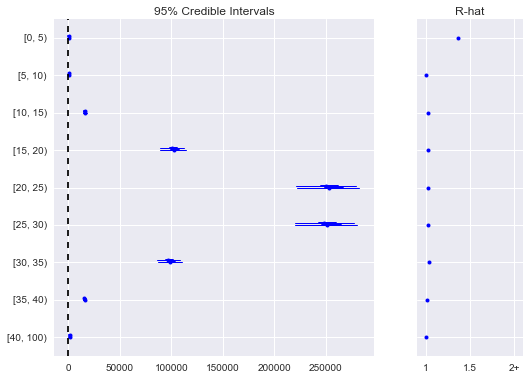

In [72]:
Matplot.summary_plot(model_june.M_0, custom_labels=age_group.categories)